## Tutorial On Sweeping and ResDMD
This tutorial will demonstrate the basic interfaces of hyperparameter sweeping and residual dmd, which can be utilized on any dmd model, for a wide range of hyperparameters. These have been fully reimplemented due to the increasing generalization of the DSA package, so like other tutorials in this folder, the goal of this notebook is to demonstrate how the interfaces are designed to be intuitive across many different DSA / DMD instances. 

There are 2 high level settings: using a Pykoopman / Pydmd model, or a local model. Then, there can be models that take in control versus not. Finally, the default setting is to sweep ranks and delays (the rank of the principal components regression and the number of delays in the delay embedding, respectively.). But there are other hyperparameters that you can sweep as well. 

Let's start with the sweeper class!

### Sweeper class


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# System dimensions
n_state = 15  # state dimension
n_control = 3  # control dimension
n_timesteps = 100  # number of time steps
n_trials = 5  # number of trials

# Sample random matrix for A and normalize to have max eigenvalue of 0.95
A_random = np.random.randn(n_state, n_state)
eigs_A = np.linalg.eigvals(A_random)
max_eig = np.max(np.abs(eigs_A))
A_true = A_random / max_eig * 0.999

# Sample random matrix for B
B_true = np.random.randn(n_state, n_control)

In [3]:
def generate_trajectory(A, B, n_timesteps, n_trials, noise_std=0.01,use_control=False,partial_observ_frac=1.0):
    """
    Generate data from a controlled linear dynamical system.
    
    Parameters:
    -----------
    A : ndarray (n_state, n_state)
        State transition matrix
    B : ndarray (n_state, n_control)
        Control input matrix
    n_timesteps : int
        Number of time steps per trial
    n_trials : int
        Number of trials
    noise_std : float
        Standard deviation of process noise
    use_control : bool 
        Whether or not the control input has any effect
    partial_observ_frac : float
        if < 1, does a partial observation legend on the states with % partial_observ_frac still observed
        will bottom out at 1
    
    Returns:
    --------
    X : ndarray (n_trials, n_timesteps, n_state)
        State trajectories
    U : ndarray (n_trials, n_timesteps, n_control)
        Control inputs
    """
    n_state = A.shape[0]
    n_control = B.shape[1]
    
    X = np.zeros((n_trials, n_timesteps, n_state))
    U = np.zeros((n_trials, n_timesteps, n_control))
    
    for trial in range(n_trials):
        # Initialize with random state
        X[trial, 0] = np.random.randn(n_state) * 0.1
        
        # Generate control inputs (random walk with some structure)
        U[trial] = np.cumsum(np.random.randn(n_timesteps, n_control) * 0.1, axis=0)
        
        # Simulate system
        for t in range(n_timesteps - 1):
            # x_{t+1} = A x_t + B u_t + noise
            drive = A @ X[trial, t] + np.random.randn(n_state) * noise_std
            if use_control:
                drive += B @ U[trial, t]
            X[trial, t + 1] = drive
    if partial_observ_frac < 1:
        n_dims = max(1,int(X.shape[-1]*partial_observ_frac))
        X = X[:,:,:n_dims]
    return X, U

# Generate training data
X_train, U_train = generate_trajectory(A_true, B_true, n_timesteps, n_trials,noise_std=0.0,partial_observ_frac=1)

print(f"Generated data shape:")
print(f"  State data X: {X_train.shape}")
print(f"  Control data U: {U_train.shape}")


Generated data shape:
  State data X: (5, 100, 15)
  Control data U: (5, 100, 3)


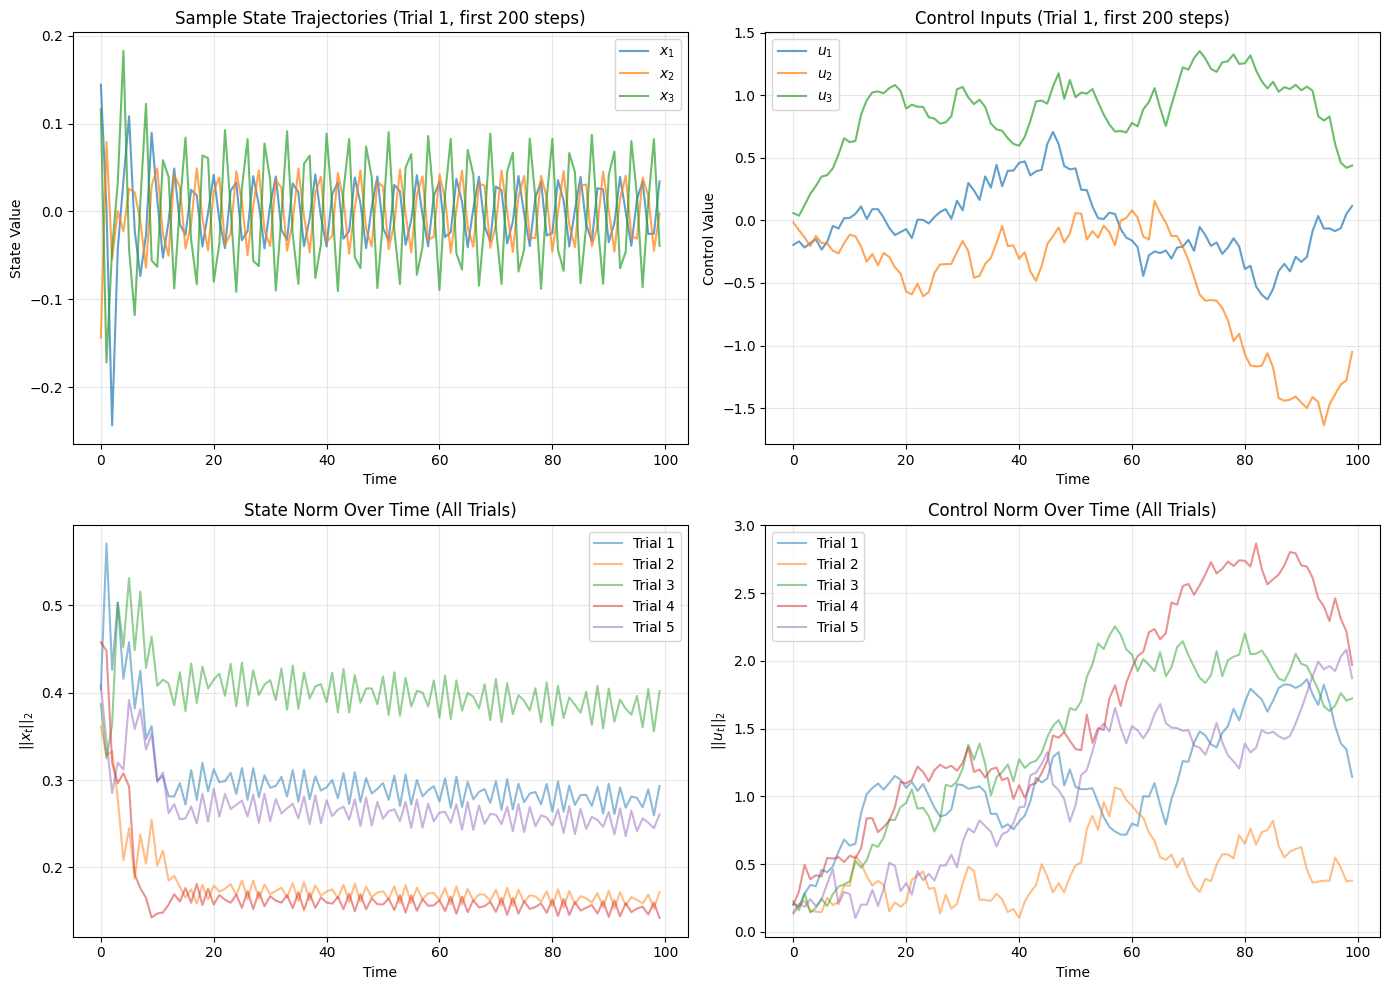

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot first few state dimensions
ax = axes[0, 0]
for i in range(min(3, n_state)):
    ax.plot(X_train[0, :200, i], label=f'$x_{{{i+1}}}$', alpha=0.7)
ax.set_xlabel('Time')
ax.set_ylabel('State Value')
ax.set_title('Sample State Trajectories (Trial 1, first 200 steps)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot control inputs
ax = axes[0, 1]
for i in range(n_control):
    ax.plot(U_train[0, :200, i], label=f'$u_{{{i+1}}}$', alpha=0.7)
ax.set_xlabel('Time')
ax.set_ylabel('Control Value')
ax.set_title('Control Inputs (Trial 1, first 200 steps)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot state norm over time
ax = axes[1, 0]
for trial in range(n_trials):
    state_norm = np.linalg.norm(X_train[trial], axis=1)
    ax.plot(state_norm, alpha=0.5, label=f'Trial {trial+1}')
ax.set_xlabel('Time')
ax.set_ylabel('$||x_t||_2$')
ax.set_title('State Norm Over Time (All Trials)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot control norm over time
ax = axes[1, 1]
for trial in range(n_trials):
    control_norm = np.linalg.norm(U_train[trial], axis=1)
    ax.plot(control_norm, alpha=0.5, label=f'Trial {trial+1}')
ax.set_xlabel('Time')
ax.set_ylabel('$||u_t||_2$')
ax.set_title('Control Norm Over Time (All Trials)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


/orcd/data/fiete/001/om2/ostrow/dmrsa/DSApublic/DSA/examples/../DSA/pykoopman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution
Sweeping: 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='reg.svd_rank', ylabel='AIC'>,
        <Axes: xlabel='reg.svd_rank', ylabel='MASE'>,
        <Axes: xlabel='reg.svd_rank', ylabel='Non-normality'>],
       dtype=object))

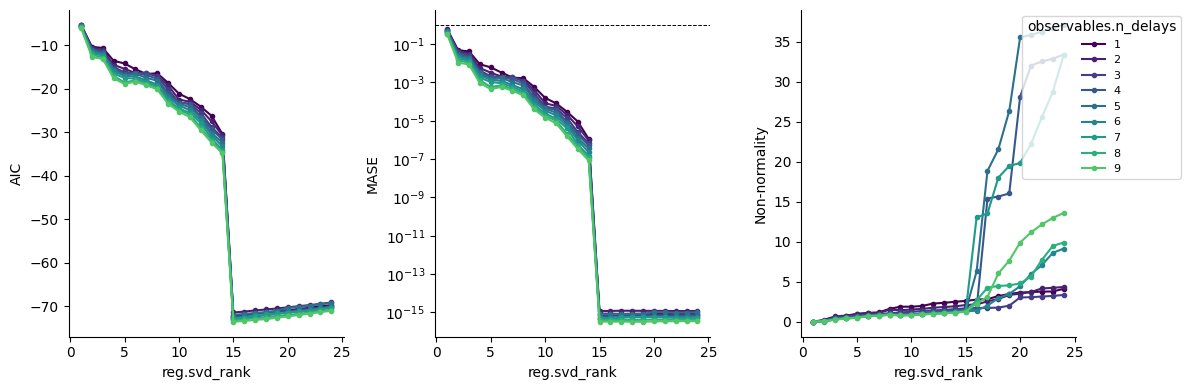

In [5]:
from DSA.sweeps import PyKoopmanSweeper
import pykoopman as pk
from pydmd import SubspaceDMD,DMD
sweeper = PyKoopmanSweeper(
    data=X_train[0],
    control_data=None,
    param1_name="observables.n_delays",
    param1_values=np.arange(1,10),
    param2_name="reg.svd_rank",
    param2_values=np.arange(1,25),
    reseed=1,
    base_regressor_class=SubspaceDMD
    # base_regressor_class=pk.regression.DMDc,  # Must use DMDc or EDMDc
)
sweeper.sweep()
sweeper.plot()

Sweeping: 100%|██████████| 7/7 [00:00<00:00, 11.19it/s]


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='reg.svd_rank', ylabel='AIC'>,
        <Axes: xlabel='reg.svd_rank', ylabel='MASE'>,
        <Axes: xlabel='reg.svd_rank', ylabel='Non-normality'>],
       dtype=object))

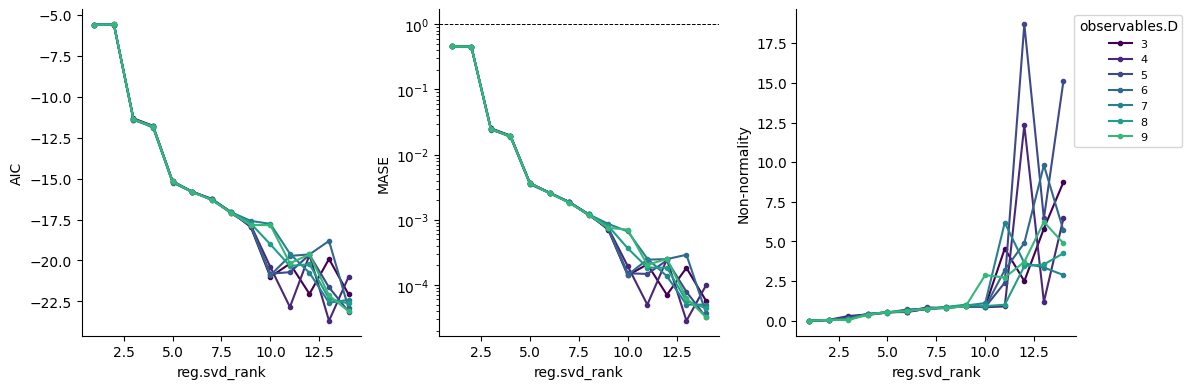

In [6]:
from DSA.sweeps import PyKoopmanSweeper
import pykoopman as pk
from pydmd import SubspaceDMD,DMD
#we can also sweep other parameters here! here we sweep the dimension of random fourier features
sweeper = PyKoopmanSweeper(
    data=X_train[0],
    control_data=None,
    param1_name="observables.D",
    param1_values=np.arange(3,10),
    param2_name="reg.svd_rank",
    param2_values=np.arange(1,15),
    reseed=1,
    base_regressor_class=SubspaceDMD,
    base_observable_class = pk.observables.RandomFourierFeatures,
    base_observable_kwargs = {'gamma':0.1,'include_state':False},
    extra_observables = pk.observables.TimeDelay(n_delays=5)
    # base_regressor_class=pk.regression.DMDc,  # Must use DMDc or EDMDc
)
sweeper.sweep()
sweeper.plot()

Sweeping:   0%|          | 0/7 [00:00<?, ?it/s]

Sweeping: 100%|██████████| 7/7 [00:00<00:00, 89.13it/s]


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='extra_obs.0.gamma', ylabel='AIC'>,
        <Axes: xlabel='extra_obs.0.gamma', ylabel='MASE'>,
        <Axes: xlabel='extra_obs.0.gamma', ylabel='Non-normality'>],
       dtype=object))

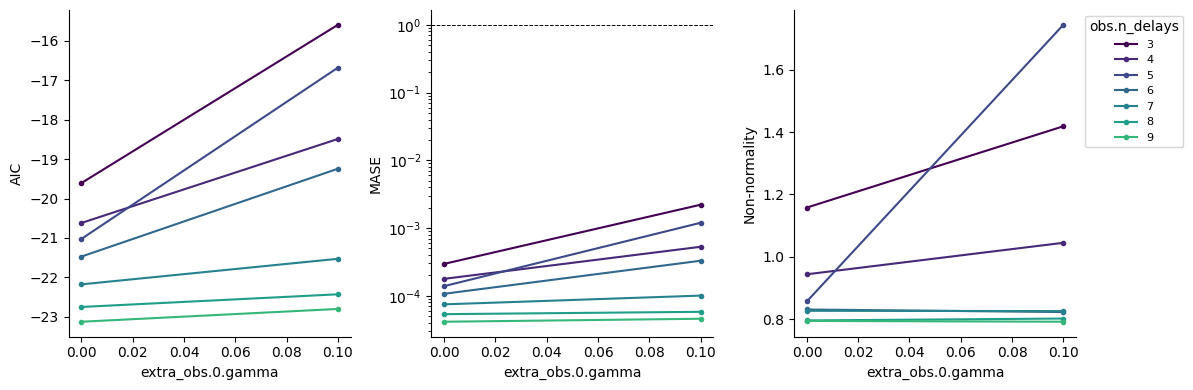

In [15]:
# Sweep TimeDelay n_delays AND RandomFourierFeatures D
sweeper = PyKoopmanSweeper(
    data=X_train[0],
    control_data=None,
    param1_name="obs.n_delays",           # Sweep TimeDelay.n_delays
    param1_values=np.arange(3, 10),
    param2_name="extra_obs.0.gamma",          # Sweep RFF.D (first extra observable)
    param2_values=[0,0.1],
    base_observable_class=pk.observables.TimeDelay,
    extra_observables=[pk.observables.RandomFourierFeatures],  # Pass CLASS, not instance
    extra_observable_kwargs=[{"include_state": False,'D':10}],  # Optional default kwargs for RFF
    base_regressor_class=SubspaceDMD,
    base_regressor_kwargs={'svd_rank':10}

)
sweeper.sweep()
sweeper.plot()

In [6]:
from DSA.sweeps import DefaultSweeper
# With control data
sweeper = DefaultSweeper(
    data=X_train,
    control_data=None, #NOte that we can still pass this in, even if it's none
    param1_name="n_delays",
    param1_values=np.arange(1,10),
    param2_name="rank",
    param2_values=np.arange(1,25),
    compute_residuals=True #
)
sweeper.sweep()

Sweeping:  33%|███▎      | 3/9 [00:00<00:00, 19.35it/s]

Sweeping: 100%|██████████| 9/9 [00:00<00:00, 10.80it/s]


(<Figure size 1600x400 with 4 Axes>,
 array([<Axes: xlabel='rank', ylabel='AIC'>,
        <Axes: xlabel='rank', ylabel='MASE'>,
        <Axes: xlabel='rank', ylabel='Non-normality'>,
        <Axes: xlabel='rank', ylabel='Avg. Residual'>], dtype=object))

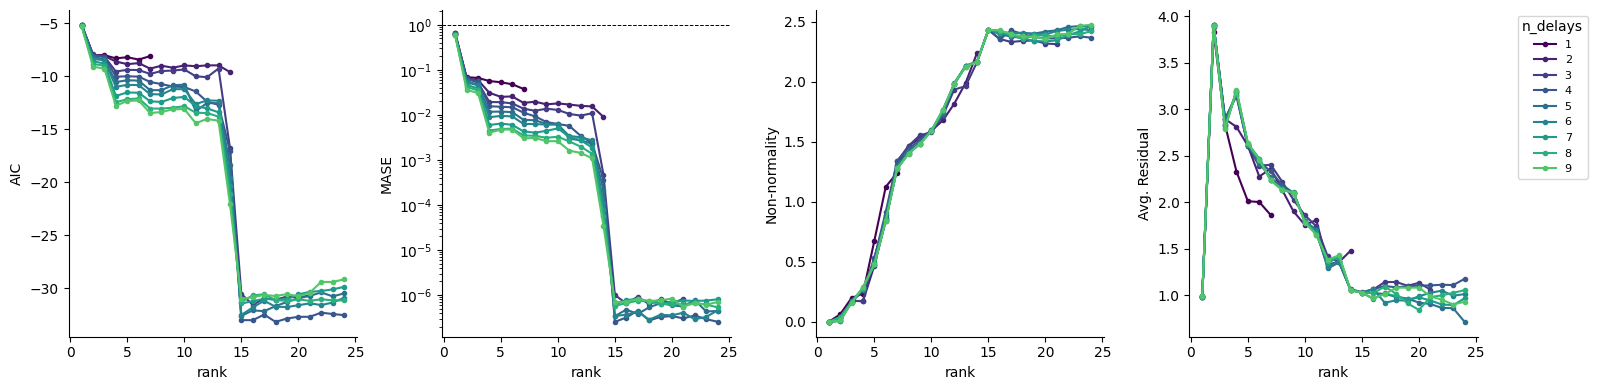

In [7]:
sweeper.plot()

In [8]:
sweeper

In [9]:
#now, let's generate data with input
# Generate training data
X_train_control, U_train_control = generate_trajectory(A_true, B_true, n_timesteps, n_trials,use_control=True,noise_std=0,partial_observ_frac=0.5)

print(f"Generated data shape:")
print(f"  State data X: {X_train_control.shape}")
print(f"  Control data U: {U_train_control.shape}")



Generated data shape:
  State data X: (5, 100, 7)
  Control data U: (5, 100, 3)


Sweeping:   0%|          | 0/4 [00:00<?, ?it/s]

Sweeping: 100%|██████████| 4/4 [00:00<00:00, 23.39it/s]


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='rank', ylabel='AIC'>,
        <Axes: xlabel='rank', ylabel='MASE'>,
        <Axes: xlabel='rank', ylabel='Non-normality'>], dtype=object))

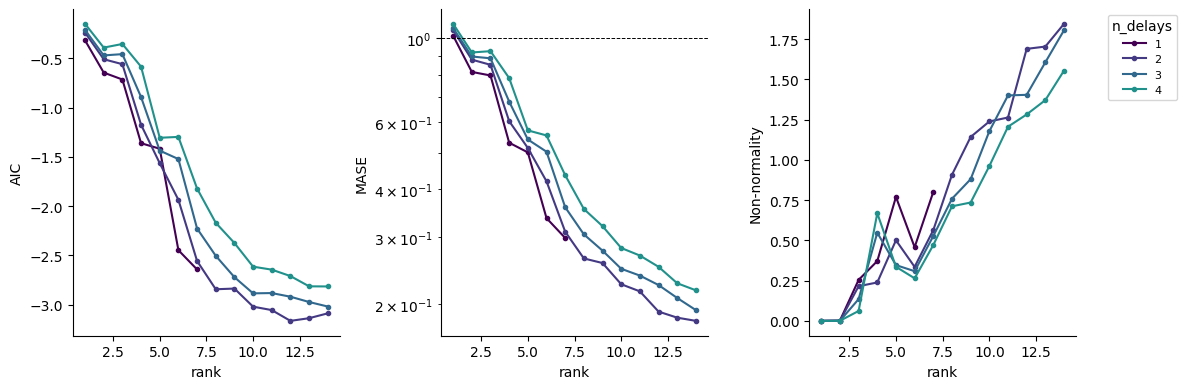

In [10]:
from DSA.sweeps import DefaultSweeper
# Without control data
sweeper = DefaultSweeper(
    data=X_train_control,
    control_data=None,
    param1_name="n_delays",
    param1_values=np.arange(1,5),
    param2_name="rank",
    param2_values=np.arange(1,15),
    model_class="DMD"
)
sweeper.sweep()
sweeper.plot()#not so clear, if we just use regular dmd now

Sweeping:   0%|          | 0/4 [00:00<?, ?it/s]

Sweeping: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='rank', ylabel='AIC'>,
        <Axes: xlabel='rank', ylabel='MASE'>,
        <Axes: xlabel='rank', ylabel='Non-normality'>], dtype=object))

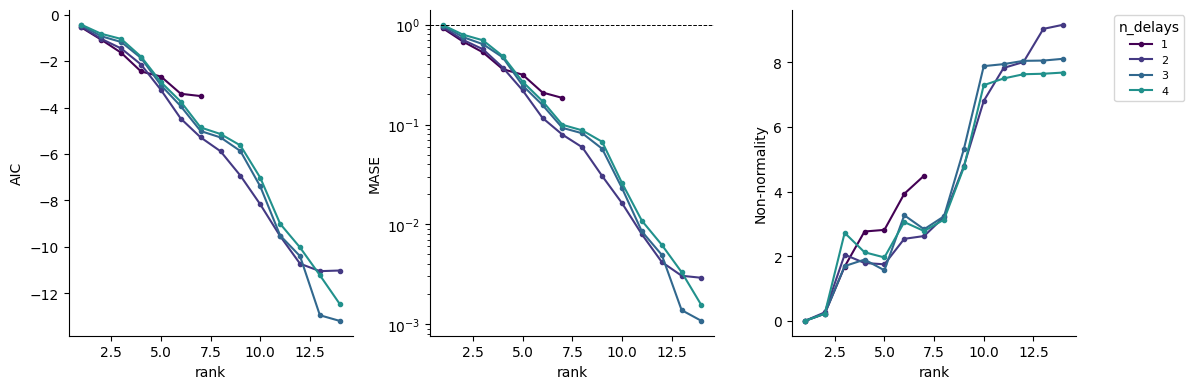

In [11]:
from DSA.sweeps import DefaultSweeper
# Without control data
sweeper = DefaultSweeper(
    data=X_train_control,
    control_data=U_train_control,
    param1_name="n_delays",
    param1_values=np.arange(1,5),
    param2_name="rank",
    param2_values=np.arange(1,15),
    model_class="SubspaceDMDc"
)
sweeper.sweep()
sweeper.plot()#not so clear, if we just use regular dmd now